## Step 1 - the dataset
The following code loads the data using npy files. We have 11,000 training examples, where each image is 64x64. Each image contains two digists $A,B \in \{1,2,3,4\}$, and the label is the product of numbers in each image $A \times B$. The label is printed at the top of each example shown below.

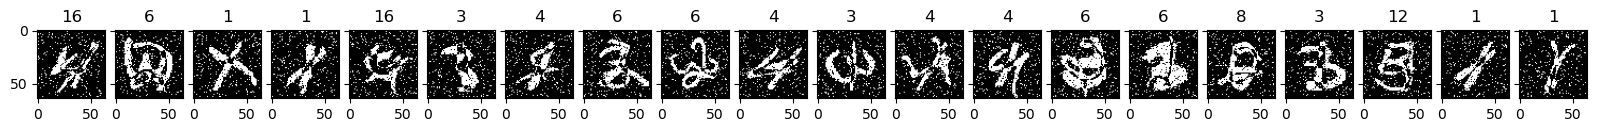

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid                         #To plot the images in grid and we have seen it befoer 

x = np.load('datasets/x_train.npy') #11,000 x 64 x 64
y = np.load('datasets/y_train.npy')
def plot_digits(x,y):
    num_plots = x.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(x[i].reshape((64,64)),cmap='gray')
        grid[i].set_title(str(y[i]))
    plt.show()
plot_digits(x[:20], y[:20])  #plot 20 first instances in the dataset 

## Step 2 - preprocessing 

In [2]:
# Imports 
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# ipyhton debugger 
import pdb


Notice in the following cell, we define objects rotater, rotater2, rotater3, perspecter, and perspecter 2. These objects are used to transform the given training data and to perform data augmentation on the training set. rotater rotates every image by 90 degrees, rotater2 rotates every image by 180 degrees, rotater3 rotates every image by 270 degrees, perspecter adds distortion of 0.2(on a scale where 1 is the max) to the images, and perspecter2 adds distortion of 0.1.(Note distortion scales of 0.7 and 0.6 were tried initially but this resulted in much worse results(worse than without any data augmentation), after some experimentation and playing around with the numbers, 0.2 and 0.1 were found to return the best results. The transformed images(whether through rotation of distortion) are then added to the training set. Thus our model is trained on a set of 66000 images instead of the 11000 images given because of data augmentation.

In [3]:

#we will approach this problem as a classification problem, there are 9 total classes
#Thus, we must make a mapping between the possible products and 0-8 otherwise we will get an error during training
#(for example error will say that 12(expected product) is out of bounds)
#these dictionaries serve as mappings for the classes
d={1: 0, 2: 1, 3: 2, 4: 3, 6: 4, 8: 5, 9: 6, 12: 7, 16: 8}
d2={0: 1, 1: 2, 2: 3, 3: 4, 4: 6, 5: 8, 6: 9, 7: 12, 8: 16}

t_data = []  #putting the data in the same format as the pytorch tutorial, also converting dtype to float
for i in range(0, len(x)):   #that way no errors since bias term will be float in training
    t_data.append((torch.tensor(np.array(x[i], dtype='float32')).view(1, 64, 64), d[y[i]]))
    
rotater = transforms.RandomRotation(degrees=(180, 180)) #defining rotations for data augmentation
rotater2 = transforms.RandomRotation(degrees=(90, 90))
rotater3 = transforms.RandomRotation(degrees=(270, 270))

perspecter = transforms.RandomPerspective(distortion_scale=0.2, p=1)  #defining distortion for data augmentation
perspecter2 = transforms.RandomPerspective(distortion_scale=0.1, p=1)


l2=[]
for i in range(0, len(t_data)):
    l2.append((rotater(t_data[i][0]), t_data[i][1]))
l3=[]
for i in range(0, len(t_data)):
    l3.append((rotater2(t_data[i][0]), t_data[i][1]))
    
l4=[]
for i in range(0, len(t_data)):
    l4.append((rotater3(t_data[i][0]), t_data[i][1]))
l5=[]
for i in range(0, len(t_data)):
    l5.append((perspecter(t_data[i][0]), t_data[i][1]))
    
l6=[]
for i in range(0, len(t_data)):
    l6.append((perspecter2(t_data[i][0]), t_data[i][1]))
    
    
t_data2=[] #t_data2 will contain all original data+other data from augmentations
for item in t_data:
    t_data2.append(item)
for item in l2:
    t_data2.append(item)
for item in l3:
    t_data2.append(item)
for item in l4:
    t_data2.append(item)
for item in l5:
    t_data2.append(item)
for item in l6:
    t_data2.append(item)

In [4]:
trainloader2 = torch.utils.data.DataLoader(t_data2, batch_size=64, shuffle=True, num_workers=2)

batch size of 64 was used, this number seems pretty standard across examples seen throughout the web

# Step 3 - the model and its training
Below we provide an example, where we apply a logistic regression model to the dataset, and we get a very bad accuracy. We can do much better by using a deep learning package in our solution.

## 3.1 example code (not using pyTorch)
The code below shows the performance of a logistic regression model which will be used as a base model in this case. 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
features = x.reshape(11000,-1) #vectorizing the input image
labels = y.reshape(-1,1)
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.33, random_state=42) #set aside 33% of the data for validation
clf = LogisticRegression()
clf.fit(x_train,y_train)
predictions = clf.predict(x_val)
accuracy = accuracy_score(y_val, predictions)
print("The validation accuracy of the model is", accuracy*100, '%')

The validation accuracy of the model is 36.94214876033058 %


## 3.2 our model!

As mentioned before, we are approaching this problem as a classification problem. There are 9 total classes possible and we implemented a mapping from the possible products to the values in range 0-8 to not get a value error while training with pytorch. This explains why the last layer of our model is a linear layer with 9 output values, where the 9 values will represent the probability of the input being in a given class. We then take the class with the largest value of these 9 outputs to make a prediction about a given input. For the other layers, we used a combination of convolutional layers, pooling layers, and linear layers. Some searching around on the internet was done to find a combination of layers that could work nicely. After some experimentation with a couple models, the one presented below was found to perform the best and so it is the one chosen.

In [6]:
## your implementation goes here!

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), padding=2)
        self.drop=nn.Dropout(p=0.5)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        
        self.fc1 = nn.Linear(64*3*3, 220)
        self.fc2=nn.Linear(220, 84)
        self.fc3=nn.Linear(84, 9)
        
    def forward(self, x):
        x= self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        #print(x.size())
        x=self.pool(F.relu(self.conv4(x)))
        #print(x.size())
        x=x.view(x.size(0), 64*3*3)
        x = F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
        
net = Net3()


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

In [8]:
#train the network

for epoch in range(10):
    #print('at epoch number '+str(epoch))
    running_loss = 0.0
    for i, data in enumerate(trainloader2):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs=net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


# Step 4 - accuracy

In [9]:
x_test = np.load('datasets/x_test.npy') #9,000 x 64 x 64
x_test_half = x_test[:4500] #the first half for which you have the true labels
y_test_half = np.load('datasets/y_test.npy') #length 4,500: you only have the true lable for the first half of the dataset 

predictions = clf.predict(np.reshape(x_test_half, (4500,-1)))
accuracy = accuracy_score(y_test_half, predictions)
print("The accuracy of the model that should match the public leaderboard accuracy is", accuracy*100, '%')


The accuracy of the model that should match the public leaderboard accuracy is 36.37777777777777 %


In [10]:

test_data = []
for i in range(0, len(x_test_half)):
    test_data.append((torch.tensor(np.array(x_test_half[i], dtype='float32')).view(1, 64, 64), d[y_test_half[i][0]]))
    
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)


# Let's see how the network performs on the whole test dataset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the test images: 80 %
